**Supporting Docs** 
* DataRobot Community Notebooks: https://github.com/datarobot-community/tutorials-for-data-scientists
  * Python modeling workflow overview: https://docs.datarobot.com/en/docs/api/modeling-workflows/python-modeling.html
  * Visual AI Pets Example: https://github.com/datarobot-community/tutorials-for-data-scientists/blob/master/VisualAI/Python/VisualAI_Oxford_Pets/VisualAI_Oxford_Pets.ipynb
* DataRobot Public Docs API: https://docs.datarobot.com/en/docs/api/index.html
* Visual AI Base64: https://docs.datarobot.com/en/docs/modeling/special-workflows/visual-ai/vai-predictions.html
* Dataset (Flower): https://datarobot.atlassian.net/wiki/spaces/CFDS/pages/1777729541/Visual+AI+Demo+and+Redistributable+Datasets
* DR Project: https://app.datarobot.com/projects/621fd63b2c539c5a19102e54/models


In [5]:
import datarobot as dr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datarobot.models.visualai import SampleImage, ImageActivationMap, ImageEmbedding
import io
import PIL.Image

import base64
import pandas as pd
from io import BytesIO
from PIL import Image

In [6]:
import streamlit as st

'https://app.datarobot.com/api/v2'

In [9]:
# dr.Client(config_path = "/Users/igor.veksler/.config/datarobot/drconfig.yaml")
dr.client(endpoint = st.secrets['endpoint'], token=st.secrets['token']) # https://github.com/datarobot-community/tutorials-for-data-scientists/blob/master/Classification/Python/lead_scoring_bank_marketing/Lead%20Scoring.ipynb

Type:        module
String form: <module 'datarobot.client' from '/usr/local/Cellar/python@3.9/3.9.1_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/datarobot/client.py'>
File:        /usr/local/Cellar/python@3.9/3.9.1_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/datarobot/client.py
Docstring:   <no docstring>


In [3]:
IMAGE_COLUMN = "image" # image column
TARGET_CLASS = "class" # target class
SAMPLE_SIZE = 5 # number of sample size for image sampling and activation maps


In [4]:
project = dr.Project.get(project_id='621fd63b2c539c5a19102e54')

In [5]:
# model = dr.ModelRecommendation.get(project.id) # Best method if 
#model = project.get_models[0]
model = dr.Model.get(project = project.id, model_id = '621fd9822ce435082a9578d1')

<AxesSubplot:xlabel='Impact Normalized', ylabel='Feature Name'>

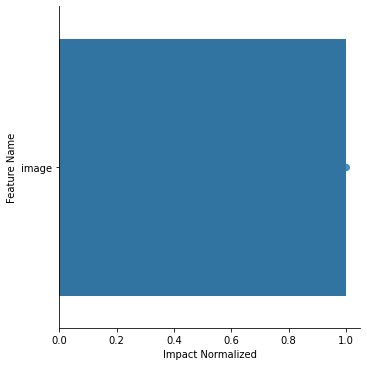

In [6]:
max_num_features = 1

# Retrieve Feature Impact
feature_impacts = model.get_or_request_feature_impact()

# Plot permutation-based Feature Impact
feature_impacts.sort(key=lambda x: x['impactNormalized'], reverse=True)
FeatureImpactDF = pd.DataFrame([{'Impact Normalized': f["impactNormalized"],
                                 'Feature Name': f["featureName"]}
                                for f in feature_impacts[:max_num_features]])
FeatureImpactDF["X axis"] = FeatureImpactDF.index

g = sns.lmplot(x="Impact Normalized", y="X axis", data=FeatureImpactDF, fit_reg=False)
sns.barplot(y=FeatureImpactDF["Feature Name"], x=FeatureImpactDF["Impact Normalized"])

<AxesSubplot:>

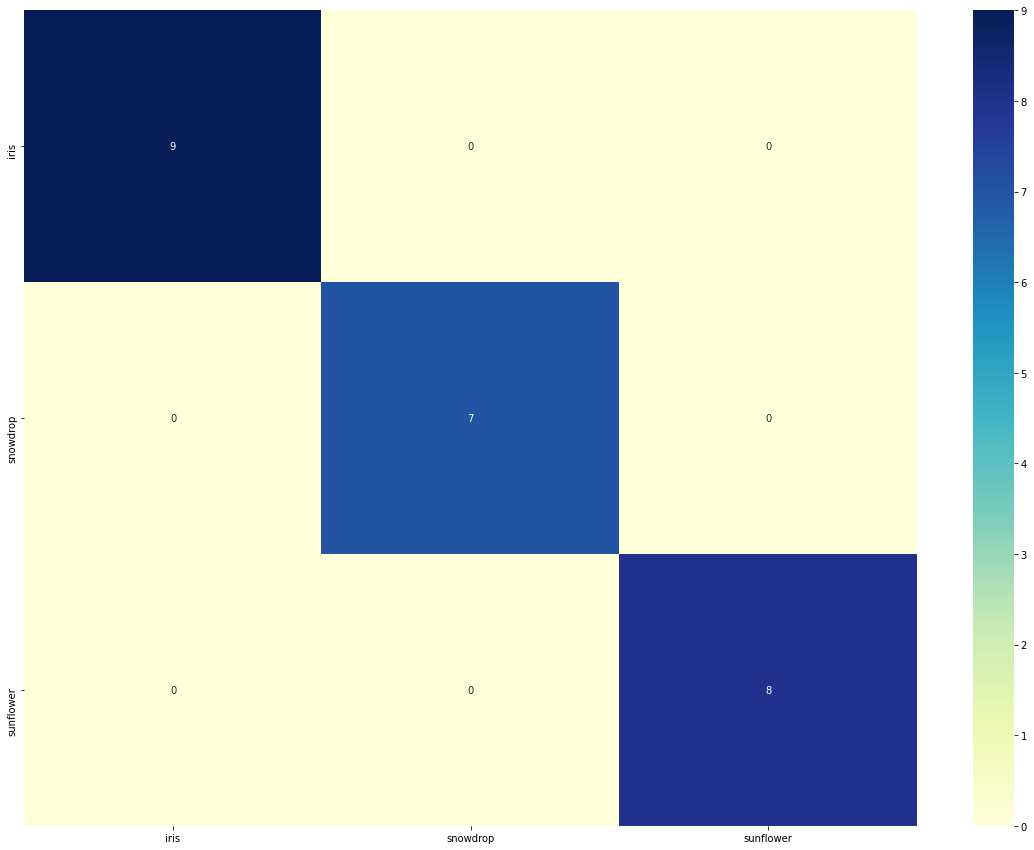

In [7]:
chart = model.get_confusion_chart(dr.enums.CHART_DATA_SOURCE.VALIDATION)

plt.subplots(figsize=(20,15))
sns.heatmap(chart.confusion_matrix, 
           annot=True, 
           xticklabels=chart.classes, 
           yticklabels=chart.classes,
           cmap='YlGnBu')

target value = sunflower


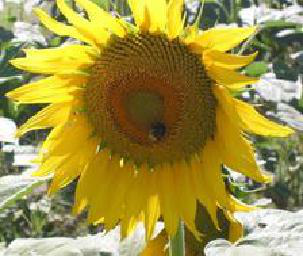

target value = snowdrop


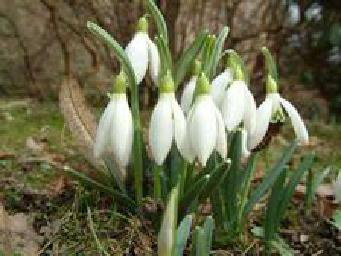

target value = sunflower


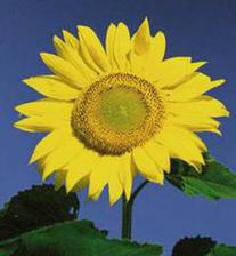

target value = snowdrop


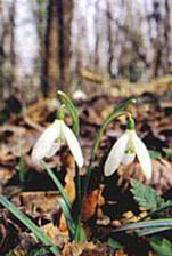

target value = iris


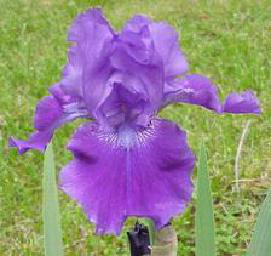

In [8]:
for sample in SampleImage.list(project.id, IMAGE_COLUMN)[:SAMPLE_SIZE]:
    print("target value = {}".format(sample.target_value))
    bio = io.BytesIO(sample.image.image_bytes)
    img = PIL.Image.open(bio)
    display(img)

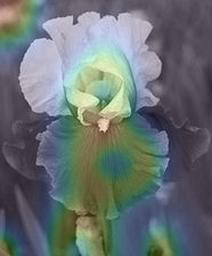

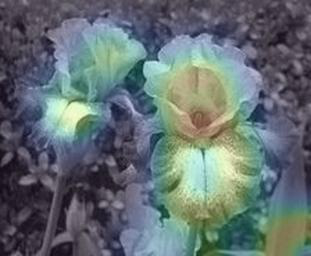

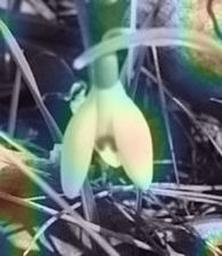

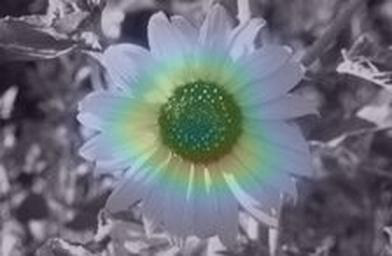

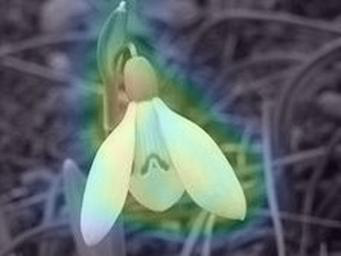

In [9]:
for model_id, feature_name in ImageActivationMap.models(project.id):
    for amap in ImageActivationMap.list(project.id, model_id, IMAGE_COLUMN)[:SAMPLE_SIZE]:
   
        bio = io.BytesIO(amap.overlay_image.image_bytes)
        img = PIL.Image.open(bio)
        display(img)

**PREDICTIONS**

In [10]:
TEST_DATA_PATH = "./image_flower_dru.zip"

# making predictions with the best model on the Leaderboard
prediction_data = project.upload_dataset(TEST_DATA_PATH)
predict_job = model.request_predictions(prediction_data.id)
result = predict_job.get_result_when_complete()

In [11]:
result

,row_id,prediction,class_iris,class_snowdrop,class_sunflower
0,0,sunflower,0.000396,0.000035,0.999570
1,1,snowdrop,0.000095,0.999770,0.000135
2,2,sunflower,0.000270,0.000007,0.999723
3,3,snowdrop,0.000097,0.999864,0.000039
4,4,iris,0.999660,0.000024,0.000316
...,...,...,...,...,...
145,145,snowdrop,0.000063,0.999559,0.000377
146,146,iris,0.999717,0.000173,0.000109
147,147,iris,0.999873,0.000081,0.000045
148,148,sunflower,0.000162,0.000001,0.999837


In [12]:
# https://docs.datarobot.com/en/docs/modeling/special-workflows/visual-ai/vai-predictions.html
def image_to_base64(image: Image) -> str:
    img_bytes = BytesIO()
    image.save(img_bytes, 'jpeg', quality=90)
    image_base64 = base64.b64encode(img_bytes.getvalue()).decode('utf-8')
    return image_base64


In [13]:
image = Image.open('./flower_image.jpeg')
image_base64 = image_to_base64(image)

df = pd.DataFrame({'image': [image_base64]})


In [14]:
df

,image
0,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAMCAgMCAgMDAw...


In [15]:
prediction_data = project.upload_dataset(df)
predict_job = model.request_predictions(prediction_data.id)
result = predict_job.get_result_when_complete()

In [16]:
result

,row_id,prediction,class_iris,class_snowdrop,class_sunflower
0,0,iris,0.999816,0.000048,0.000135
